$$\textbf{Section 1: Random numbers}$$

1) Python has many built-in random number generators. Check-out the documentation and try a couple of ones. In particular, compare the output of the built-in expontential and Gaussian generators with the versions implemented above.

On commence par implémenter les éléments qui nous servent pour le codage:

In [85]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
from matplotlib import rcParams
from matplotlib import animation
from IPython.display import HTML
import matplotlib.cm as cm 
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

La première distribution que nous voulons comparer est la distribution uniforme, dont la ''built-in function'' de python est *numpy.random.uniform*. On réalise immédiatemment un histogramme des valeurs rendues par cette fonction. 

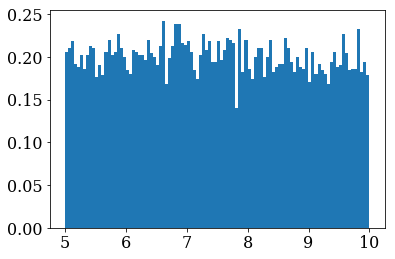

In [86]:
h=plt.hist(np.random.uniform(5,10,10000), bins=100, normed=True)
plt.show()

Avec la méthode ''à la main'' proposées dans le MOOC, nous obtenons l'histogramme suivant:

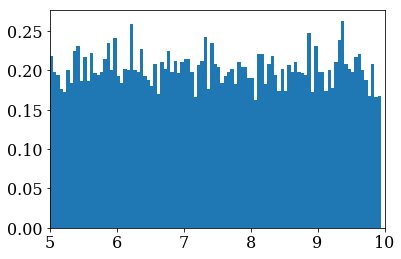

In [87]:
a=5
b=10
x = np.random.random_sample(10000)
y = (b-a)*x+a
binwidth=0.05
plt.xlim(5,10)
plt.hist(y,bins=np.arange(5.,10., binwidth),normed=True);

On compare maintenant les distributions gaussiennes. On commence par celle qui est proposée directement par Python, *numpy.random.normal*.

On essaye de créer une distribution de moyenne $$\mu =0$$
et d'écart-type $$\sigma=0.1$$
On a superposé l'équation analytique d'une telle gaussienne pour s'assurer que nous avons utilisé la bonne "built-in function".

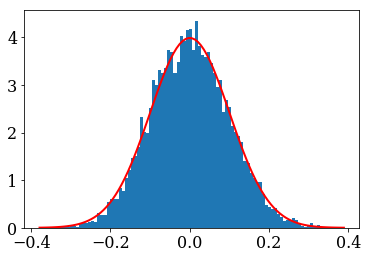

In [88]:
mu, sigma =0,0.1
gauss=np.random.normal(mu,sigma,10000)
count, bins, ignored=plt.hist(gauss, bins=100, normed=True)
plt.plot(bins, 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(bins-mu)**2 / (2*sigma**2)), linewidth=2, color='r')
plt.show()

Finalement, nous regardons la distribution exponentielle. La fonction fournie par Python est *numpy.random.exponential*. Nous testons avec $$\alpha=\frac{1}{4}$$

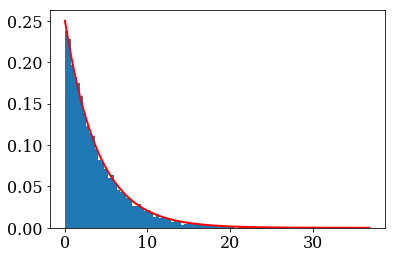

In [89]:
exp=np.random.exponential(4,10000)
count, bins, ignored=plt.hist(exp, bins=100, normed=True)
plt.plot(bins, 1/4*np.exp(-bins / 4), linewidth=2, color='r')
plt.show()

La méthode proposée dans le MOOC impliquait l'utilisation des ''distributions inversibles", ce qui dans le cas de l'exponentielle nous rendait: 
$$
F^{-1}(x) = -\frac{1}{\alpha}\log(1-x).
$$

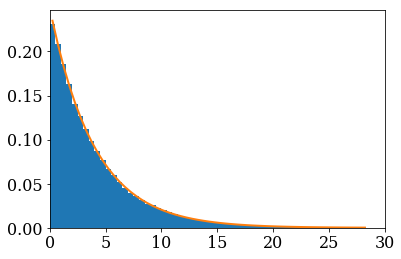

In [90]:
alpha = 0.25 # rate of the exponential distribution
x = np.random.random_sample(100000)
y = -1/alpha*np.log(1-x)

# Plots
binwidth=0.5
plt.xlim(0,30)
bins=np.arange(0.,29., binwidth)
plt.hist(y,bins,normed=True);

# Compute centers of bins
xc = bins[:-1] + binwidth/2
plt.plot(xc,alpha*np.exp(-alpha*xc), lw=2)

2) Another popular method to generate numbers according to the Gaussian distribution is known as the Box–Muller algorithm. Look up its definition on the web, try to implement it and verify that it works as expected.

On s'aide de l'article Wikipédia portant sur la méthode Box-Muller:  https://fr.wikipedia.org/wiki/M%C3%A9thode_de_Box-Muller . 

On constate qu'il existe deux écritures: la transformation de Box-Muller à proprement parler, et la méthode polaire. Nous allons implémenter la première, plus simple, car la seconde requiert que l'on rejette certaines combinaisons de nombres aléatoires s'ils ne satisfont pas à certaines conditions.

On va donc générer N paires de nombres aléatoires (x,y) uniformément distribués entre ]0,1].

In [91]:
N=1000
x = np.random.random_sample(N)
y = np.random.random_sample(N)

On définit ensuite la transformation pour obtenir deux variables $z_0$ et $z_1$ qui vont suivre une loi normale centrée réduite.
$$z_0=\sqrt{-2log(x)}cos(2\pi y)$$
$$z_1=\sqrt{-2log(x)}sin(2\pi y)$$

In [92]:
def boxmuller(x,y):
    z0 = np.sqrt(-2*np.log(x))*np.cos(2*np.pi*y)
    z1 = np.sqrt(-2*np.log(x))*np.sin(2*np.pi*y)
    return z0,z1

On applique ensuite la transformation aux N paires (x,y) que nous avons générées, et on réalise un histogramme pour $z_0$ et $z_1$pour vérifier qu'on a bien une loi normale centrée réduite, en superposant la courbe d'une telle loi.

In [93]:
z0,z1=boxmuller(x,y)

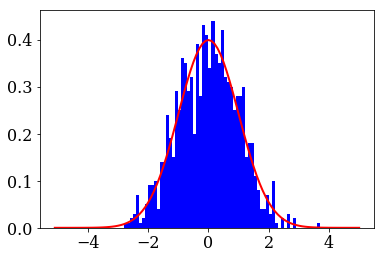

In [94]:
binwidth=0.1
sigma=1
mu=0
bins=np.arange(-5.1,5.1, binwidth)
plt.hist(z0,bins=np.arange(-5.,5., binwidth),normed=True,color='blue')
plt.plot(bins, 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(bins-mu)**2 / (2*sigma**2)), linewidth=2, color='r')

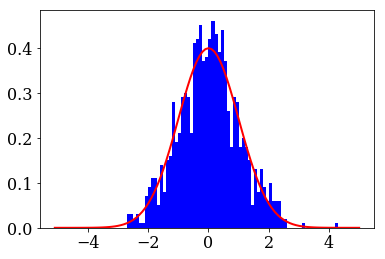

In [95]:
binwidth=0.1
bins=np.arange(-5.1,5.1, binwidth)
plt.hist(z1,bins=np.arange(-5.,5., binwidth),normed=True,color='blue')
plt.plot(bins, 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(bins-mu)**2 / (2*sigma**2)), linewidth=2, color='r')

$$\textbf{Section 3: Brownian Motion}$$

$$\textbf{Section 4: Ising Model}$$

1) Check that this is not a coincidence and that the metropolis algorithm gives the correct ratio of "ups" and "downs" for different lattice configurations. You may use the following routine to generate different ones with random initial dipole orientations.

Commençons par réutiliser des fonctions du MOOC dont nous aurons besoin pour ce challenge

In [96]:
def initial_state(nx,ny):
    """ Creates a lattice with random spin orientations
   
    Parameters:
    ----------
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
   
    Returns:
    -------
    r: 2D array of spins
    """
       
    # Uniform random spins between 0 and 1  
    r = np.random.randint(0,2,(nx,ny))
    
    # Where r=0, we assign a negative spin
    r[r==0] =-1

    return r

In [97]:
def energy_at_site(sp,alpha,sigma,ix,iy):
    """ Computes the contribution to the energy for a given spin
    at location ix,iy for a lattice with periodic boundary conditions
   
    Parameters:
    ----------
    sp: numpy array
        array of spins
    alpha  : real
        coupling constant J/(kb*T)
    sigma   : int
        spin at site ix,iy
    ix   : int
        location in x
    iy   : int
        location in y
    
   
    Returns:
    -------
    energy: energy for the given configuration
    """
    
    energy=-alpha*sigma*(sp[(ix-1)%nx,iy]+sp[(ix+1)%nx,iy]+sp[ix,(iy-1)%ny]+sp[ix,(iy+1)%ny])

    return energy

In [98]:
def metropolis_at_site(sp,alpha,ix,iy):
    """ Flips a dipole at site ix, iy when probability condition is met 
   
    Parameters:
    ----------
    sp: numpy array
        array of spins
    alpha  : real
        coupling constant J/(kb*T)
    ix   : int
        location in x
    iy   : int
        location in y
    """
    sigma=sp[ix,iy]
    energy_before_flip = energy_at_site(sp,alpha,sigma,ix,iy)
    sigma = -sigma
    energy_if_site_flipped = energy_at_site(sp,alpha,sigma,ix,iy)
    
    # Flip the site with Metropolis probability
    # Condition is always satisifed if dE < 0
    if (np.random.random_sample()<np.exp(-(energy_if_site_flipped \
                                               -energy_before_flip))):
        sp[ix,iy]=-sp[ix,iy]

On va ensuite créer N=5 ''lattices'' carrés de différentes tailles. Le premier est de taille 7x7, le second de taille (7+5)x(7+5), etc. 

On met tous ces états initiaux dans une grande matrice $sp$. On se permet d'utiliser la fontion $append$, le faible nombre d'itérations. 

In [99]:
sp=[]
nx=7
ny=7
for n in range(5):
    spi=initial_state(nx,ny)
    sp.append(spi)
    nx=nx+5
    nx=ny+5

On va ensuite appliquer l'algorithme Metropolis, pour aléatoirement retourner un dipôle afin de créer une série de NMC états, pour chacun des lattices. On va vérifier systématiquement le rapport spin up/spin down au point (5,5). 

Le lattice sur lequel on travaille est appelé $current$.

En parallèle, on calcule le rapport par la formule:
$$
\frac{p({\rm up})}{p({\rm downs})} = e^{-\Delta E}
$$
la différence d'énergie étant prise entre un état où le dipôle n'a pas été retourné, et l'état où il l'a été.

In [100]:
alpha = 0.1
for k in range (5):
    NMC = 100000
    states = np.empty(NMC+1)
    current=sp[k]
    states[0]=current[5,5]

    for n in range(0,NMC):
        metropolis_at_site(current,alpha,5,5)
        states[n]=current[5,5]

    ups = np.extract(states==1, states).size
    downs = NMC - ups
    unflip=energy_at_site(current,alpha,-1,5,5)
    flip= energy_at_site(current,alpha,1,5,5)
    print(np.exp(-(flip-unflip)), (ups/downs))

2.22554092849 2.2134708698865646
1.49182469764 1.4912184549463143
1.49182469764 1.4904119141305971
2.22554092849 2.2145038413320903
0.670320046036 0.6715699384862263


On constate bien que l'algorithme Metropolis fonctionne bien comme on le souhaite, et nous rend bien le même rapport que si on calcule l'exponentielle de la différence d'énergie. 


2) Perform a series of runs with $\alpha \in$ [0, 1] and plot the average energy of the system and its magnetisation as a function of $\alpha$ . Estimate the critical value of  αα at which the phase transition occurs. Is it compatible with Onsager's exact solution for the system?

On a besoin de la fonction ising_model_metropolis, définie dans le MOOC:

In [101]:
def ising_model_metropolis(sp, NMC, nx, ny, alpha):
    """ Creates a sequence of states for the Ising model using
    the Metropolis algorithm
   
    Parameters:
    ----------
    sp   : initial lattice state
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
    NMC  : int
        Number of states to create
    alpha  : real
        coupling constant J/(kb*T)
    Returns:
    -------
    states: sequence of states
    """
    states = np.empty([NMC+1,nx,ny])
    states[0] = sp.copy()
    
    for i in range(1,NMC+1):
        for j in range(0,nx*ny):
            ix=np.random.randint(0,nx)
            iy=np.random.randint(0,ny)
            metropolis_at_site(sp,alpha,ix,iy)
        states[i]=sp.copy()
    return states

On commence par créer d'une part une liste $index$ $alpha$ de 50+1 valeurs de alpha, entre 0 et 1. D'autre part

In [102]:
num=50
alpha1=0
states_tot=[]
nx=10
ny=10
index_alpha=np.zeros(num+1)
index_alpha[0]=alpha1
sp = np.ones([nx,ny])
states_alpha=ising_model_metropolis(sp, NMC, nx, ny, alpha1)
states_tot.append(states_alpha)
for i in range(num):
    NMC=100
    alpha1=alpha1+(1/num)
    index_alpha[i+1]=alpha1
    sp = np.ones([nx,ny])
    states_alpha=ising_model_metropolis(sp, NMC, nx, ny, alpha1)
    states_tot.append(states_alpha)
print(index_alpha)

[ 0.    0.02  0.04  0.06  0.08  0.1   0.12  0.14  0.16  0.18  0.2   0.22
  0.24  0.26  0.28  0.3   0.32  0.34  0.36  0.38  0.4   0.42  0.44  0.46
  0.48  0.5   0.52  0.54  0.56  0.58  0.6   0.62  0.64  0.66  0.68  0.7
  0.72  0.74  0.76  0.78  0.8   0.82  0.84  0.86  0.88  0.9   0.92  0.94
  0.96  0.98  1.  ]


In [103]:
length=len(index_alpha)

In [104]:
energy_alpha=[]
for i in range(length):
    energy_tot=0
    current_alpha=states_tot[i]
    alpha=index_alpha[i]
    for k in range(NMC):
        current_state=current_alpha[k]
        for n in range(nx):
            for j in range(ny):
                ener=energy_at_site(current_state,alpha,-1,n,j)
                energy_tot=energy_tot+ener
    energy_alpha.append(energy_tot/(2*length))
#energy_alpha=np.asarray(energy_alpha)
print(energy_alpha)

[0.0, -0.018823529411764808, 0.13803921568627442, 0.023529411764704352, 1.0854901960784176, -0.031372549019609224, 1.5341176470588298, 2.086274509803931, 0.90352941176470059, 0.88941176470588301, 3.8431372549019849, 3.9168627450980229, -0.92235294117647737, 10.236862745097852, 9.7286274509802961, 2.8470588235294105, 12.097254901960602, 43.039999999999466, 23.858823529412291, -14.842352941176349, 112.21960784314786, 131.53411764707334, 145.56235294118383, 154.34352941177505, 172.00941176469681, 176.98039215686279, 192.95058823532, 201.43058823528585, 212.09725490198318, 217.35215686272409, 231.05882352943817, 236.08627450977221, 246.91450980395248, 255.87294117643617, 262.2400000000269, 271.27058823525044, 280.48941176472749, 289.09333333327254, 296.60862745104174, 303.61882352938403, 312.4078431373041, 320.79686274505514, 328.68705882356903, 336.91764705878103, 344.20078431373929, 352.79999999993379, 360.1349019608088, 368.111372548985, 375.71764705878491, 384.08313725480519, 392.15686

In [105]:
mag_alpha=[]
for i in range(length):
    mag_tot=0
    current_alpha=states_tot[i]
    alpha=index_alpha[i]
    for k in range(NMC):
        current_state=current_alpha[k]
        for n in range(nx):
            for j in range(ny):
                mag=current_state[n,j]
                mag_tot=mag_tot+mag
    mag_alpha.append(mag_tot/length)
#mag_alpha=numpy.asarray(mag_alpha)
print(mag_alpha)

[0.0, -0.47058823529411764, 1.7254901960784315, 0.19607843137254902, 6.784313725490196, -0.15686274509803921, 6.3921568627450984, 7.4509803921568629, 2.8235294117647061, 2.4705882352941178, 9.6078431372549016, 8.9019607843137258, -1.9215686274509804, 19.686274509803923, 17.372549019607842, 4.7450980392156863, 18.901960784313726, 63.294117647058826, 33.137254901960787, -19.529411764705884, 140.27450980392157, 156.58823529411765, 165.41176470588235, 167.76470588235293, 179.1764705882353, 176.98039215686273, 185.52941176470588, 186.50980392156862, 189.37254901960785, 187.37254901960785, 192.54901960784315, 190.39215686274511, 192.90196078431373, 193.84313725490196, 192.8235294117647, 193.76470588235293, 194.78431372549019, 195.33333333333334, 195.13725490196077, 194.62745098039215, 195.25490196078431, 195.60784313725489, 195.64705882352942, 195.88235294117646, 195.56862745098039, 196.0, 195.72549019607843, 195.80392156862746, 195.68627450980392, 195.9607843137255, 196.07843137254903]


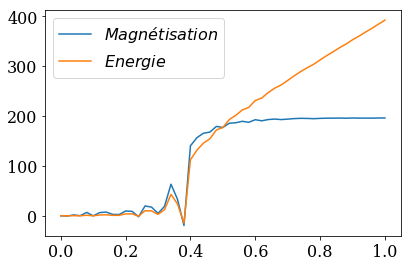

In [106]:
plt.figure()
plt.plot(index_alpha,mag_alpha, label=r'$Magnétisation$')
plt.plot(index_alpha,energy_alpha, label=r'$Energie$')
plt.legend()
plt.tight_layout()